In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Display a dataset
!ls "/content/drive/MyDrive/new-skinnea-ds"

test  train  val


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [4]:
train_dir='/content/drive/MyDrive/new-skinnea-ds/train'

In [5]:
Labels = ['Atopic-Dermatitis', 'Poison-Ivy', 'Scabies-Lyme']

In [6]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Atopic-Dermatitis
1 Poison-Ivy
2 Scabies-Lyme


In [7]:
print('Number of classes:',len(Labels))

Number of classes: 3


In [8]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [9]:
IMAGE_SIZE

(224, 224)

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 54 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [11]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [12]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [13]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2,915,395
Trainable params: 657,411
Non-trainable params: 2,257,984
___________________

In [14]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [15]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
3/3 [==============================] - 19s 6s/step - loss: 2.3166 - accuracy: 0.3158 - val_loss: 2.5878 - val_accuracy: 0.2500
Epoch 2/15
3/3 [==============================] - 5s 2s/step - loss: 1.2703 - accuracy: 0.5526 - val_loss: 1.5997 - val_accuracy: 0.4375
Epoch 3/15
3/3 [==============================] - 6s 2s/step - loss: 0.6941 - accuracy: 0.6842 - val_loss: 1.4862 - val_accuracy: 0.5625
Epoch 4/15
3/3 [==============================] - 5s 2s/step - loss: 0.1932 - accuracy: 0.9474 - val_loss: 2.1375 - val_accuracy: 0.4688
Epoch 5/15
3/3 [==============================] - 5s 2s/step - loss: 0.4532 - accuracy: 0.8684 - val_loss: 2.2388 - val_accuracy: 0.4062
Epoch 6/15
3/3 [==============================] - 4s 2s/step - loss: 0.4064 - accuracy: 0.8947 - val_loss: 1.5186 - val_accuracy: 0.4688
Epoch 7/15
3/3 [==============================] - 7s 3s/step - loss: 0.1762 - accuracy: 0.9375 - val_loss: 1.1703 - val_accuracy: 0.5312
Epoch 8/15
3/3 [========================

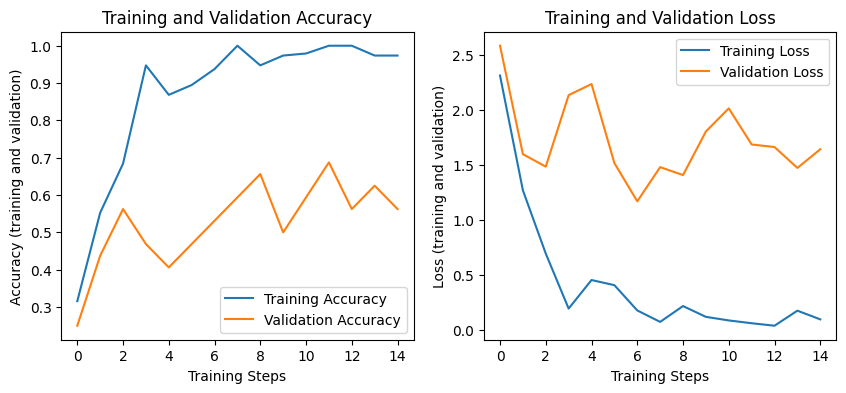

In [16]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 0s 52ms/step
class: Poison-Ivy, confidence: 0.917367


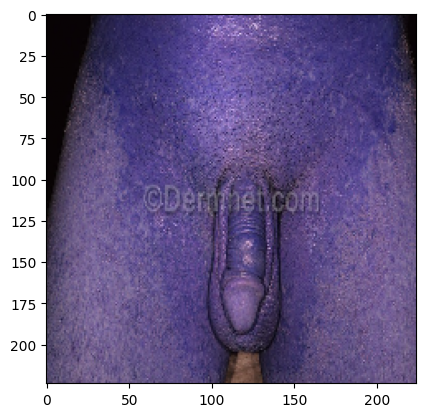

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 59ms/step
class: Scabies-Lyme, confidence: 0.929170


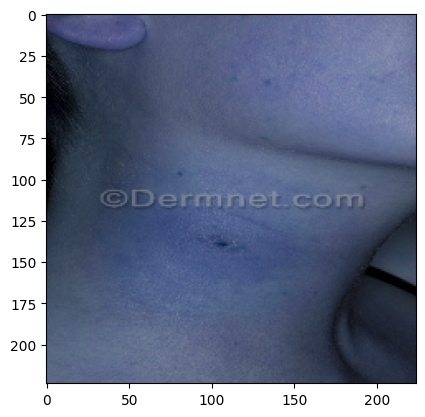

1/1 [==============================] - 0s 98ms/step
class: Atopic-Dermatitis, confidence: 0.506371


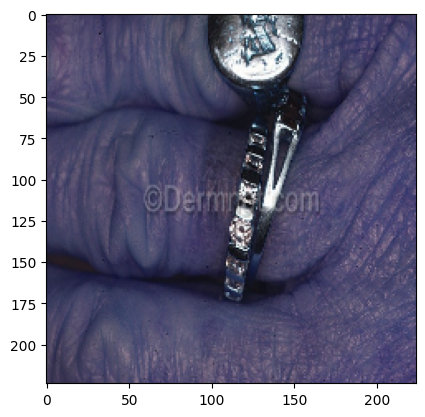

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 88ms/step
class: Poison-Ivy, confidence: 0.926727


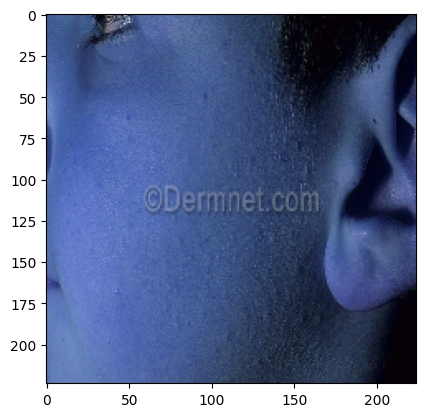

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 90ms/step
class: Poison-Ivy, confidence: 0.928918


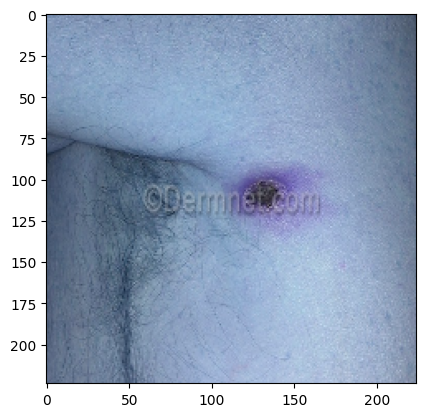

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 90ms/step
class: Poison-Ivy, confidence: 0.997632


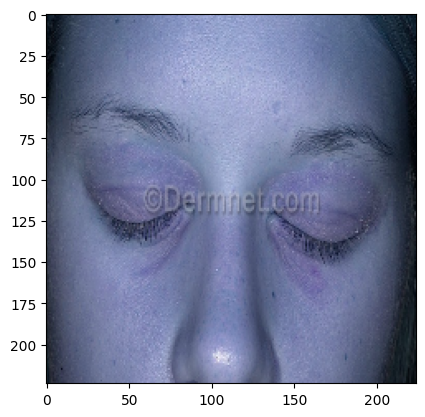

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 89ms/step
class: Poison-Ivy, confidence: 0.999101


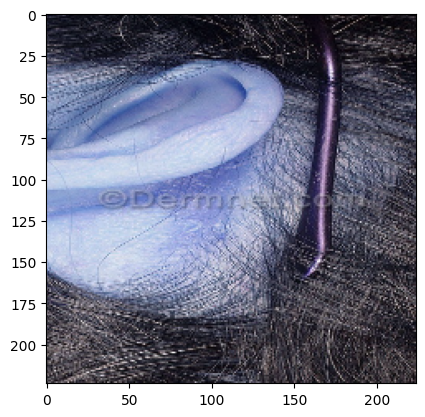

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 92ms/step
class: Scabies-Lyme, confidence: 0.925907


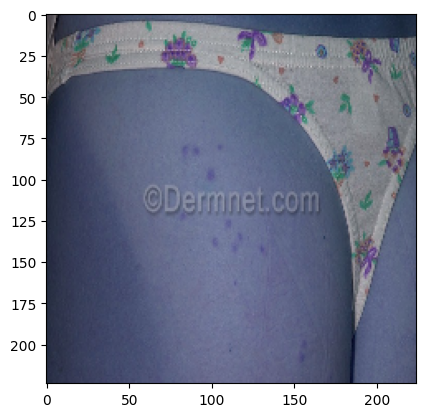

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 90ms/step
class: Scabies-Lyme, confidence: 0.990220


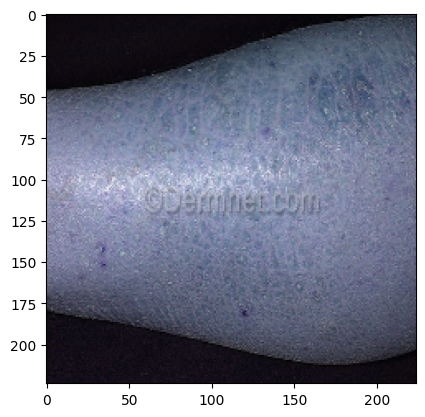

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 96ms/step
class: Scabies-Lyme, confidence: 0.614088


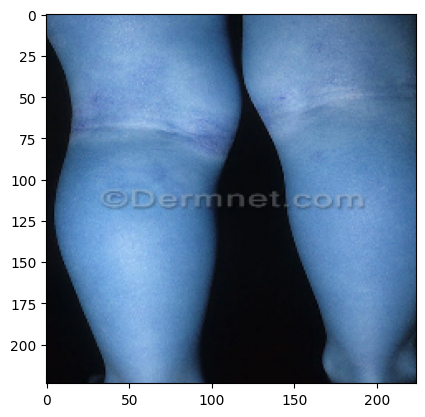

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 111ms/step
class: Poison-Ivy, confidence: 0.999121


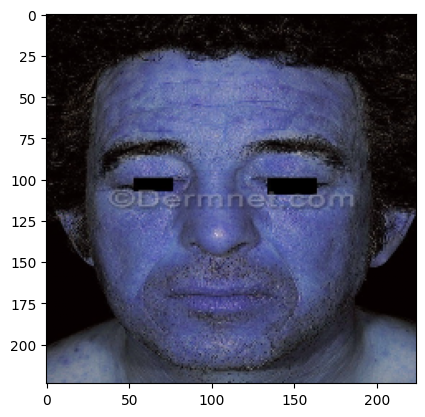

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 81ms/step
class: Scabies-Lyme, confidence: 0.500557


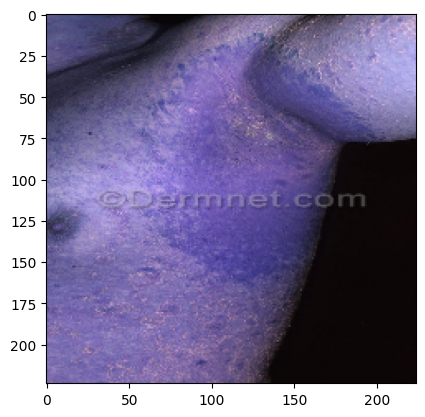

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 94ms/step
class: Poison-Ivy, confidence: 0.768615


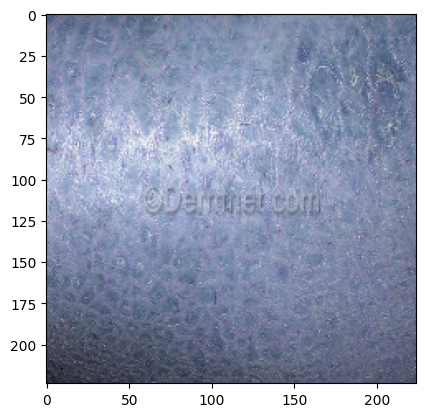

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 94ms/step
class: Scabies-Lyme, confidence: 0.883160


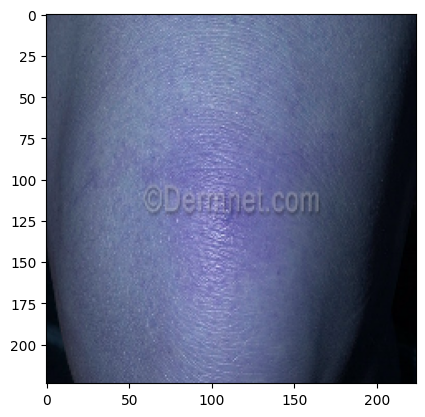

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 91ms/step
class: Scabies-Lyme, confidence: 0.843573


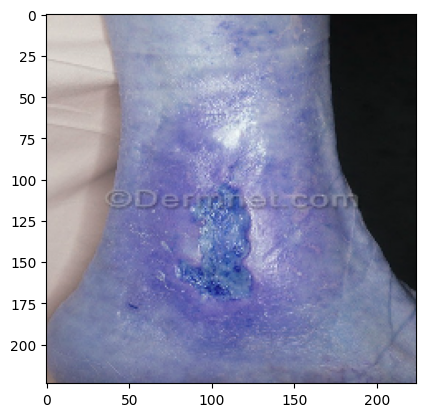

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 86ms/step
class: Atopic-Dermatitis, confidence: 0.803837


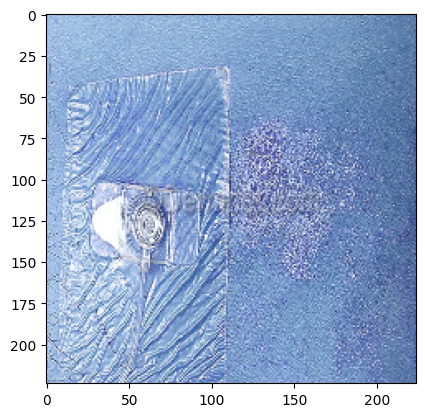

<Figure size 640x480 with 0 Axes>

In [44]:
import random
import cv2

def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img / 255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()


In [47]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

3/3 [==============================] - 2s 307ms/step
Classification Report
                   precision    recall  f1-score   support

Atopic-Dermatitis       0.58      0.58      0.58        12
       Poison-Ivy       0.69      0.75      0.72        12
     Scabies-Lyme       0.73      0.67      0.70        12

         accuracy                           0.67        36
        macro avg       0.67      0.67      0.67        36
     weighted avg       0.67      0.67      0.67        36

3/3 [==============================] - 3s 599ms/step - loss: 1.3200 - accuracy: 0.6667
[1.3199896812438965, 0.6666666865348816]


Confusion Matrix


<Axes: >

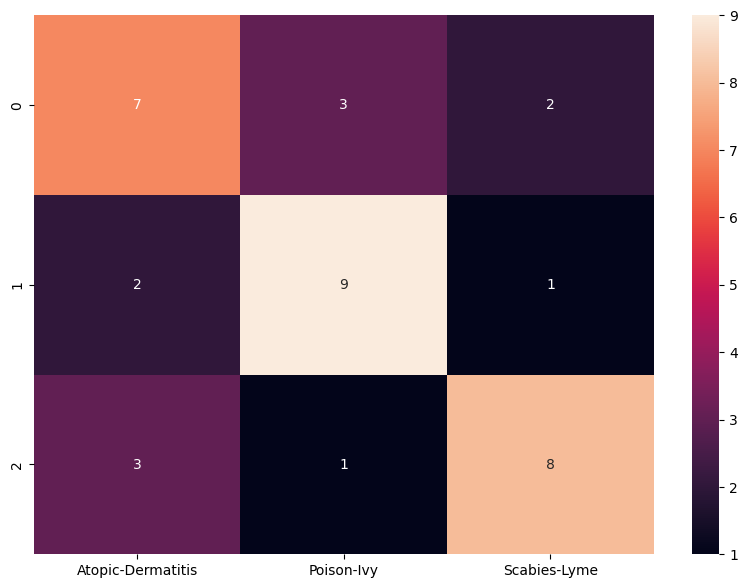

In [48]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

#Export as saved model and convert to TFLite

In [49]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

'/tmp/saved_models/1685580814'

In [50]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [51]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: Scabies-Lyme, file: Scabies-Lyme/Scabies-Lyme (13).jpg
1/1 [==============================] - 0s 146ms/step
PREDICTED: class: Scabies-Lyme, confidence: 0.768440


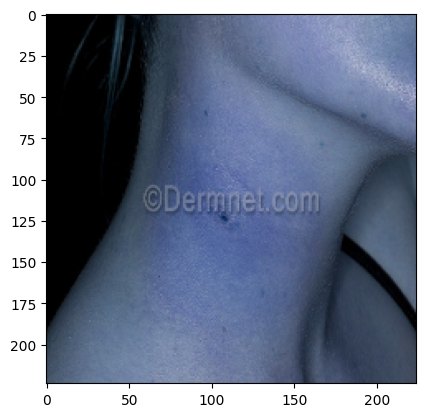

<Figure size 640x480 with 0 Axes>

SOURCE: class: Poison-Ivy, file: Poison-Ivy/Poison-Ivy (18).jpg
1/1 [==============================] - 0s 221ms/step
PREDICTED: class: Poison-Ivy, confidence: 0.917367


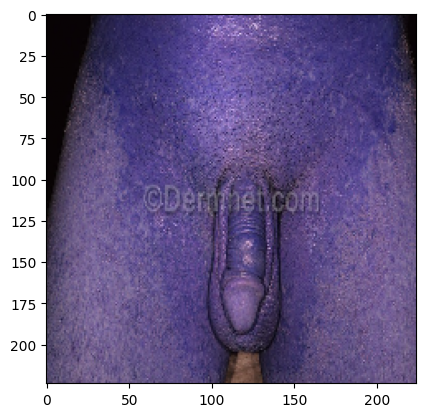

SOURCE: class: Scabies-Lyme, file: Scabies-Lyme/Scabies-Lyme (1).jpg
1/1 [==============================] - 0s 358ms/step
PREDICTED: class: Scabies-Lyme, confidence: 0.931890


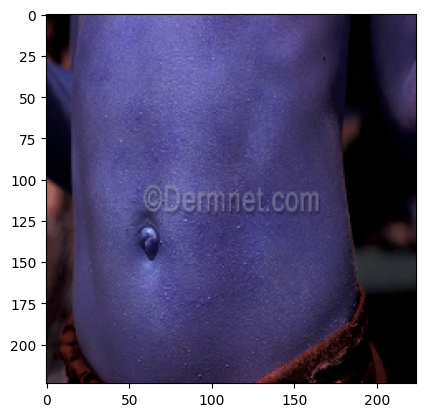

<Figure size 640x480 with 0 Axes>

SOURCE: class: Poison-Ivy, file: Poison-Ivy/Poison-Ivy (17).jpg
1/1 [==============================] - 0s 237ms/step
PREDICTED: class: Poison-Ivy, confidence: 0.998679


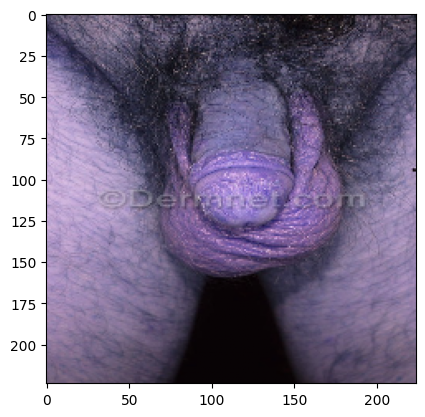

<Figure size 640x480 with 0 Axes>

SOURCE: class: Atopic-Dermatitis, file: Atopic-Dermatitis/Atoppic-Dermatitis (13).jpg
1/1 [==============================] - 0s 102ms/step
PREDICTED: class: Poison-Ivy, confidence: 0.926727


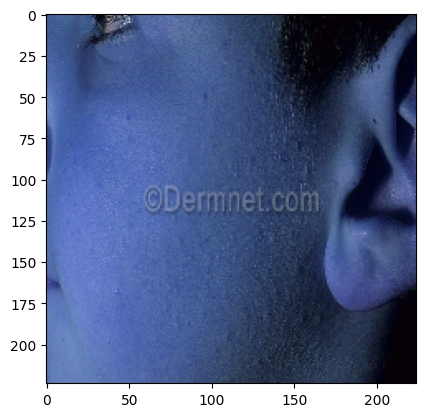

<Figure size 640x480 with 0 Axes>

In [53]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [54]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11544872

In [55]:
from google.colab import files

# Tentukan path file tflite yang akan didownload
tflite_path = "/content/tflite_models/model.tflite"

# Download file tflite
files.download(tflite_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>